In [2]:
import cv2
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from torchvision.utils import save_image

In [2]:
def normalize_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = rgb2gray(image)
    return (image - np.min(image)) / (np.max(image) - np.min(image))

In [3]:
def process_folder(folder_path, output_path=None):
    for filename in os.listdir(folder_path):
        if filename.endswith("png"):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            normalized_image = normalize_image(image)
            if output_path:
                save_path = os.path.join(output_path, filename)
                cv2.imwrite(save_path, normalized_image * 255)
            else:
                cv2.imwrite(image_path, normalized_image * 255)

In [ ]:
# NIST Special Dataset
input_base_path = "../Datasets/NIST Special Database 302/SD 302a/challengers"
output_base_path = "../Datasets/NIST Special Database 302/SD 302a/challengers"

# Process images from folders A to H
for folder_name in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    data_path = os.path.join(input_base_path, folder_name, "roll", "png")
    output_path = os.path.join(output_base_path, folder_name, "roll", "Normalised_Images", "Real")
    os.makedirs(output_path, exist_ok=True)
    process_folder(data_path, output_path)

In [20]:
# Set random seed
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)

In [21]:
# Parameters
dataroot = "../Datasets/NIST Special Database 302/SD 302a/challengers"
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
real_label = 1
generated_label = 0
num_classes = 8  # Number of device classes A to H

In [22]:
# Initialize weights function
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [23]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, num_classes):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + num_classes, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, inp, labels):
        labels = labels.view(labels.size(0), labels.size(1), 1, 1)
        inp = torch.cat((inp, labels), dim=1)
        return self.main(inp)

In [24]:
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc + num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, inp, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1)  # Add two dimensions to labels
        labels = labels.repeat(1, 1, inp.size(2), inp.size(3))  # Repeat labels across width and height
        inp = torch.cat((inp, labels), dim=1)
        return self.main(inp)

In [25]:
# Custom dataset class with labels
class LabeledImageFolder(dset.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, loader=dset.folder.default_loader):
        super(LabeledImageFolder, self).__init__(root, transform, target_transform, loader)

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

In [26]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = dset.ImageFolder(root=dataroot, transform=transform)

In [27]:
# Initialize dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [28]:
device = torch.device("mps" if (torch.cuda.is_available()) else "cpu")

In [29]:
generator = Generator(nz, ngf, num_classes).to(device)
generator.apply(init_weights)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(108, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [30]:
discriminator = Discriminator(num_classes).to(device)
discriminator.apply(init_weights)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [31]:
# Loss function and optimizers
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [32]:
# Training loop
G_losses = []  # List to store generator losses
D_losses = []  # List to store discriminator losses
img_list = []  # List to store generated images for visualization

In [33]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Move real images and labels to the appropriate device
        real_cpu, labels = data[0].to(device), torch.eye(num_classes)[data[1]].to(device)

        # Create labels for real and fake images
        real_label = torch.full((real_cpu.size(0),), 1., device=device)
        fake_label = torch.full((real_cpu.size(0),), 0., device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        discriminator.zero_grad()
        # Forward pass real batch through D
        output_real = discriminator(real_cpu, labels).view(-1)
        errD_real = criterion(output_real, real_label)
        D_x = output_real.mean().item()

        # Generate fake images
        noise = torch.randn(real_cpu.size(0), nz, 1, 1, device=device)
        fake = generator(noise, labels)

        # Forward pass fake batch through D
        output_fake = discriminator(fake.detach(), labels).view(-1)
        errD_fake = criterion(output_fake, fake_label)
        D_G_z1 = output_fake.mean().item()

        # Total discriminator loss
        errD = errD_real + errD_fake
        # Update discriminator
        errD.backward()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake, labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, real_label)
        # Update generator
        errG.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, output.mean().item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (epoch % 10 == 0 and i == len(dataloader) - 1):
            with torch.no_grad():
                fixed_noise = torch.randn(64, nz, 1, 1, device=device)
                fixed_labels = torch.eye(num_classes)[torch.randint(0, num_classes, (64,))].to(device)
                fake = generator(fixed_noise, fixed_labels)
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting Training Loop...
[0/5][0/213]	Loss_D: 1.7281	Loss_G: 2.3840	D(x): 0.4194	D(G(z)): 0.3956 / 0.4306
[0/5][50/213]	Loss_D: 0.0362	Loss_G: 5.4417	D(x): 0.9832	D(G(z)): 0.0165 / 0.0063
[0/5][100/213]	Loss_D: 0.1749	Loss_G: 4.1993	D(x): 0.9188	D(G(z)): 0.0733 / 0.0272
[0/5][150/213]	Loss_D: 0.3358	Loss_G: 2.6330	D(x): 0.8236	D(G(z)): 0.0968 / 0.1355
[0/5][200/213]	Loss_D: 0.2841	Loss_G: 2.6314	D(x): 0.9022	D(G(z)): 0.1529 / 0.0923
[1/5][0/213]	Loss_D: 0.8975	Loss_G: 1.9672	D(x): 0.7041	D(G(z)): 0.3294 / 0.2232
[1/5][50/213]	Loss_D: 3.2323	Loss_G: 0.8963	D(x): 0.0871	D(G(z)): 0.0160 / 0.4928
[1/5][100/213]	Loss_D: 1.2328	Loss_G: 2.1658	D(x): 0.5210	D(G(z)): 0.3285 / 0.1424
[1/5][150/213]	Loss_D: 1.1927	Loss_G: 1.1781	D(x): 0.4650	D(G(z)): 0.2659 / 0.3434
[1/5][200/213]	Loss_D: 0.8584	Loss_G: 2.8729	D(x): 0.8905	D(G(z)): 0.4731 / 0.0736
[2/5][0/213]	Loss_D: 0.7931	Loss_G: 1.6412	D(x): 0.6401	D(G(z)): 0.2502 / 0.2251
[2/5][50/213]	Loss_D: 0.7509	Loss_G: 2.4148	D(x): 0.8566	D(G(z)): 0.4

In [34]:
# Save the model checkpoints
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
    'G_losses': G_losses,
    'D_losses': D_losses
}, 'conditional_gan_checkpoint.pth')

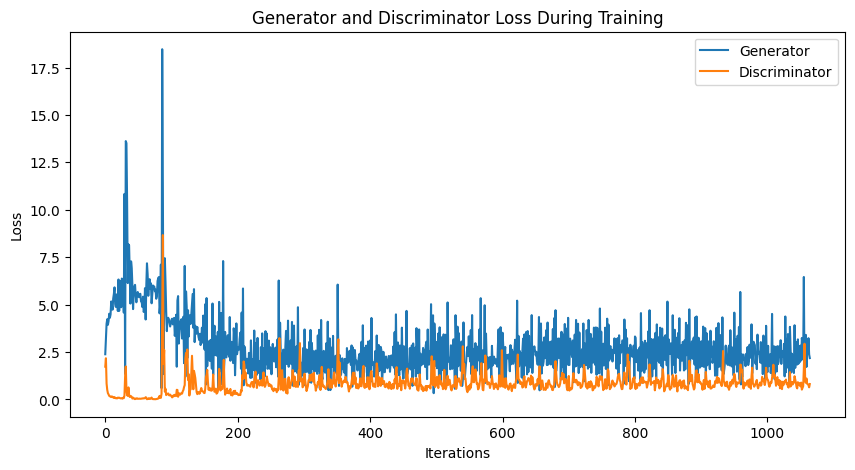

In [35]:
# Plot Generator and Discriminator loss
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [37]:
# Save the generated images
output_dir = "Generated_Images_NIST_Special_Dataset"
os.makedirs(output_dir, exist_ok=True)
for i, images in enumerate(img_list):
    save_image(images, os.path.join(output_dir, f"generated_image_{i}.png"))

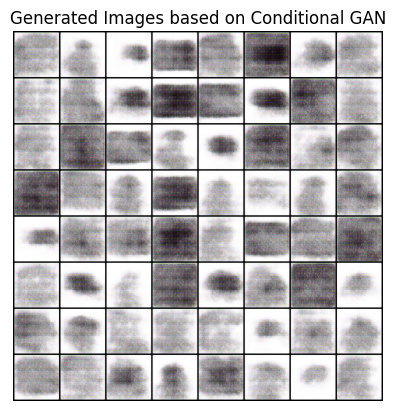

In [5]:
image_path = "Generated_Images_NIST_Special_Dataset/generated_image_0.png"  # Replace with the path
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Generated Images based on Conditional GAN")
plt.axis('off')
plt.show()